In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
plt.style.use('./plots/paper.mplstyle') #Use custom stylesheet
import pandas as pd
import ks_custom as ksc
import sklearn as skl
import scipy.stats as sps
from scipy.special import erf as errorfunc
from scipy.special import erfinv as errorfuncinv
import sw_scripts as sws
import sw_lib as sw

datapath = './data/' #Path to data
modelpath = './modelstore/' #Path to models/hyperparameters
plotpath = './plots/' #Path to plot storage

#Fix Random Seed
seed = 888 #Lucky!
np.random.seed(seed) #Seed the NP generator

#Color and 390099
c1 = '#892b64'
c2 = '#b54e5a'
c3 = '#d27450'
c4 = '#e29d53'
c5 = '#e9c46a'
r = '#B7094C'
b = '#0091AD'

sheath_colors = [(137/255.0, 43/255.0, 100/255.0),
                 (181/255.0, 78/255.0, 90/255.0),
                 (210/255.0, 116/255.0, 80/255.0),
                 (226/255.0, 157/255.0, 83/255.0),
                 (233/255.0, 196/255.0, 106/255.0)]
primesh = LinearSegmentedColormap.from_list('primesh', sheath_colors, N=10000)

new_oranges_colors = [(253/255.0, 240/255.0, 237/255.0),
                      (220/255.0, 60/255.0, 24/255.0)]
new_oranges = LinearSegmentedColormap.from_list('new_oranges', new_oranges_colors, N=10000)

new_purples_colors = [(250/255.0, 239/255.0, 246/255.0),
                     (137/255.0, 43/255.0, 100/255.0)]
new_purples = LinearSegmentedColormap.from_list('new_purples', new_purples_colors, N=10000)

rb_colors = [(183/255.0, 9/255.0, 76/255.0),
             (137/255.0, 43/255.0, 100/255.0),
             (92/255.0, 77/255.0, 125/255.0),
             (0/255.0, 145/255.0, 173/255.0)]
rb = LinearSegmentedColormap.from_list('rb', rb_colors, N=10000)

In [2]:
#Target Dataset
mms_data = pd.read_hdf(datapath + 'mms_data.h5', key = 'targets', mode = 'a')
mms_data = ksc.nightside_cut(mms_data, conesize = np.pi/2) #Cut out the nightside data since classification is unreliable there
mms_data.loc[:, ['R_xgse', 'R_ygse', 'R_zgse']] #Scale to Earth Radii
mms_sh = mms_data.drop(mms_data[mms_data['region']!=1].index) #Magnetosheath Data

#Input Datatset
wind_data = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_combined', mode = 'a')
wind_sh_ind = ksc.closest_argmin(mms_sh['Epoch'].to_numpy(), wind_data['Epoch'].to_numpy()) #Get the indices of the wind dataset closest to each target time

#Load the data
in_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Vth', 'R_xgse', 'R_ygse', 'R_zgse', 'target_R_xgse', 'target_R_ygse', 'target_R_zgse'] #Wind data keys to include in input dataset
tar_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni'] #Targets from MMS dataset to match

window = 55 #Input window length (100s units)
stride = 16 #Stride away from target (100s units)
inter_frac = 0.05 #How many interpolated points in a row to tolerate
flag = 'tdelt' #Whether to cut inputs as a percent of total or length of maximum interpolated stretch of data
conesize = np.pi/2 #Size of the cone to cut the MMS data to (radians)
print('Loading data...')
ds = ksc.load_dataset(datapath + 'mms_data.h5', datapath + 'wind_data.h5','sh', in_keys, tar_keys, split_frac=0.2, window=window, stride=stride, inter_frac=int(window*inter_frac), flag=flag, tar_storekey = 'targets', in_storekey='wind_combined', conesize = conesize, vx_cut=False, table_cut=False)
print('Data loaded! Dataset shape: ' + str(ds.in_full.shape))

mms_cut = mms_sh[ds.ds_mask]
mms_train = mms_cut.iloc[ds.inds_train]
mms_test = mms_cut.iloc[ds.inds_test]

#Load saved model outputs (old_outputs.h5)
predict_test = pd.read_hdf(datapath + 'sheath_outputs.h5', key = 'prime_predict_test', mode = 'a')
predict = pd.read_hdf(datapath + 'sheath_outputs.h5', key = 'prime_predict', mode = 'a')
predict_full = pd.read_hdf(datapath + 'sheath_outputs.h5', key = 'prime_predict_full', mode = 'a')
#predict_mp = pd.read_hdf(datapath + 'sheath_outputs.h5', key = 'prime_predict_mp', mode = 'a')
predict_test[['R_xgse', 'R_ygse', 'R_zgse']] = mms_test[['R_xgse', 'R_ygse', 'R_zgse']]

#Load OMNI data and select the test set
omni_full = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_shift', mode = 'a') #load shifted omni data
omni_test = omni_full.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just the test set
cut_test = ((omni_test.index.duplicated()) | (omni_test['Timeshift_mms']>100)) #Cut out bad data
omni_test.loc[cut_test, omni_test.columns!='Epoch'] = np.nan #Set bad data to nan
omni_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_test.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test

omni_sh = omni_full.iloc[ksc.closest_argmin(mms_sh['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
cut_sh = ((omni_sh.index.duplicated()) | (omni_sh['Timeshift_mms']>100)) #Cut out bad data
omni_sh.loc[cut_sh, omni_sh.columns!='Epoch'] = np.nan #Set bad data to nan
omni_sh.index = mms_sh.index #Set the index to the mms test set index for ease of comparison
omni_sh.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test

Loading data...


/home/connor/.cache/pypoetry/virtualenvs/primesh-yvOHzGvw-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Data loaded! Dataset shape: (74592, 55, 14)


/tmp/ipykernel_3967/1507170504.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_test.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
/tmp/ipykernel_3967/1507170504.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_sh.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test


/tmp/ipykernel_3967/707570960.py:9: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_3967/707570960.py:10: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_3967/707570960.py:11: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_3967/707570960.py:13: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_3967/707570960.py:14: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and

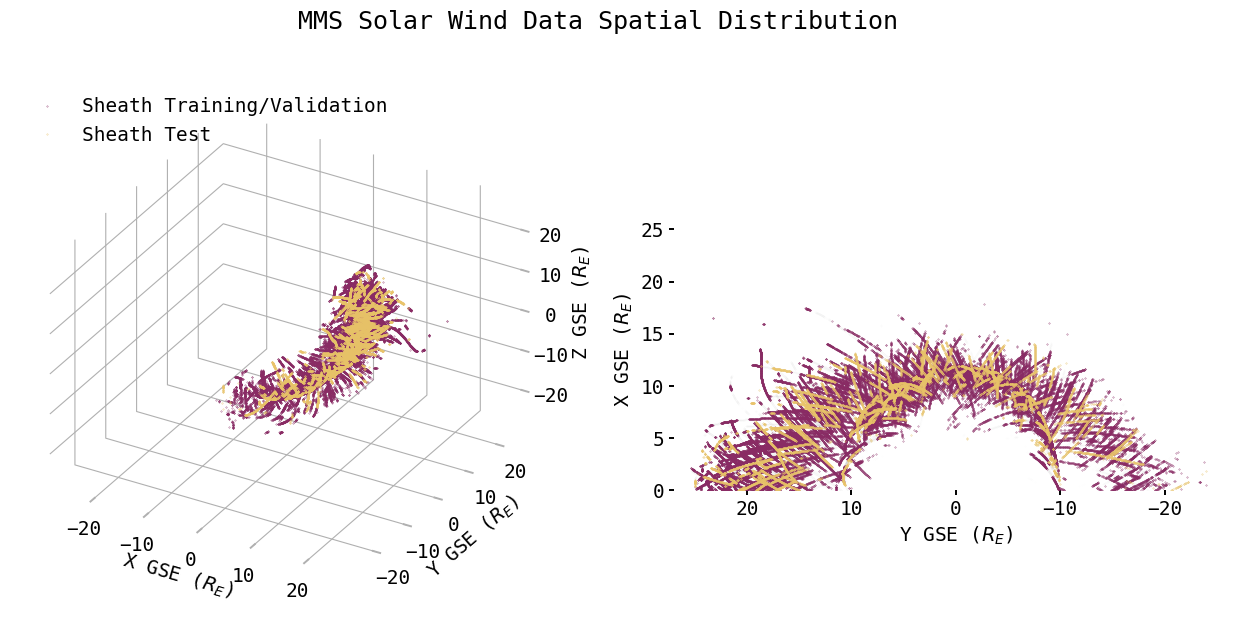

In [3]:
#Plot the MMS solar wind data in 3D
fig = plt.figure(figsize=(16,7))
fig.suptitle('MMS Solar Wind Data Spatial Distribution', fontsize = 18)
ax = fig.add_subplot(121, projection='3d')
ax.plot(mms_train['R_xgse'], mms_train['R_ygse'], mms_train['R_zgse'], '.', markersize = 0.5, c = c1, label = 'Sheath Training/Validation')
ax.plot(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', markersize = 0.5, c = c5, label = 'Sheath Test')
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='x', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='y', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='z', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_xlim(-27,27)
ax.set_ylim(-27,27)
ax.set_zlim(-27,27)
ax.legend(fontsize = 14, loc = 'upper left')

ax2 = fig.add_subplot(122)
ax2.plot(mms_sh['R_ygse'], mms_sh['R_xgse'], '.', c = 'grey', alpha = 0.02, markersize = 0.5)
ax2.plot(mms_train['R_ygse'], mms_train['R_xgse'], '.', c = c1, markersize = 0.5)
ax2.plot(mms_test['R_ygse'], mms_test['R_xgse'], '.', c = c5, markersize = 0.5)
ax2.set_aspect('equal')
ax2.set_ylim(0, 27)
ax2.set_ylabel(r'X GSE ($R_{E}$)')
ax2.set_xlim(27, -27)
ax2.set_xlabel(r'Y GSE ($R_{E}$)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#plt.savefig('./plots/mms_sw_3d_test.png', bbox_inches = 'tight', dpi = 300)

In [8]:
def crps_func(mu, sg, y):
    ep = np.abs(y - mu)
    crps = sg * ((ep/sg) * errorfunc(ep/(np.sqrt(2)*sg)) + np.sqrt(2/np.pi) * np.exp(-ep**2 / (2*sg**2)) - 1/np.sqrt(np.pi))
    return crps

def crps_min_f(mu, y):
    '''
    Helper function that calculates min continuous rank probability scores
    '''
    ep = np.abs(y - mu)
    N = len(ep)
    crps_min = (np.sqrt(np.log(4.0))/(2*N)) * np.sum(ep)
    return crps_min

mms_test['pdyn'] = sw.pdyn(mms_test['Ni'], mms_test['Vi_xgse'])
mms_train['pdyn'] = sw.pdyn(mms_train['Ni'], mms_train['Vi_xgse'])
mms_sh['pdyn'] = sw.pdyn(mms_sh['Ni'], mms_sh['Vi_xgse'])
predict_test['pdyn'] = sw.pdyn(predict_test['Ni'], predict_test['Vi_xgse'])
predict_test['pdyn_sig'] = sw.pdyn_err(predict_test['Ni'], predict_test['Vi_xgse'], predict_test['Ni_sig'], predict_test['Vi_xgse_sig'])
mms_test['B'] = np.sqrt(mms_test['B_ygsm']**2 + mms_test['B_zgsm']**2)
predict_test['B'] = np.sqrt(predict_test['B_ygsm']**2 + predict_test['B_zgsm']**2)
predict_test['B_sig'] = sw.mag_err(0, 0, predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig'])
mms_test['theta'] = np.arctan2(mms_test['B_ygsm'], mms_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the MMS data
predict_test['theta'] = np.arctan2(predict_test['B_ygsm'], predict_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the predicted data
predict_test['theta_sig'] = sw.theta_err(predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig']) #Calculate the uncertainty in the IMF clock angle for the predicted data


keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'pdyn'] #Keys for the data parameters to be compared
keys_sig = [key+'_sig' for key in keys]
labels = ['Bx (nT)', 'By (nT)', 'Bz (nT)', 'Vx (km/s)', 'Vy (km/s)', 'Vz (km/s)', '$n_{i}$ (cm$^{-3}$)', '$P_{dyn}$ (nPa)'] #Labels for the data parameters to be compared
predict_error = crps_func(predict_test[keys], predict_test[keys_sig].to_numpy(), mms_test[keys]) #Calculate the CRPS between the predicted and mms test sets
predict_error_min = crps_min_f(predict_test[keys], mms_test[keys]) #Calculate the minimum possible CRPS between the predicted and mms test sets
predict_error['Epoch'] = pd.to_datetime(mms_test['Epoch'], unit='s', utc=True) #Add the time column back in
predicted_mae = np.mean(np.abs(predict_test[keys] - mms_test[keys]), axis = 0)
print('PRIME CRPS:\n', np.mean(np.abs(predict_error[keys]), axis = 0)) #Print the CRPS for each parameter
print('PRIME Min CRPS:\n', predict_error_min) #Print the minimal CRPS for each parameter
print('PRIME MAE:\n', predicted_mae) #Print the MAE for each parameter

PRIME CRPS:
 B_xgsm      2.638645
B_ygsm      4.244902
B_zgsm      5.288574
Vi_xgse    15.412936
Vi_ygse    12.744288
Vi_zgse    15.974825
Ni          3.770550
pdyn        0.273408
dtype: float64
PRIME Min CRPS:
 B_xgsm      2.119588
B_ygsm      3.385749
B_zgsm      4.252171
Vi_xgse    12.493157
Vi_ygse    10.069336
Vi_zgse    12.882010
Ni          3.074435
pdyn        0.224200
dtype: float64
PRIME MAE:
 B_xgsm      3.600424
B_ygsm      5.751182
B_zgsm      7.222924
Vi_xgse    21.221421
Vi_ygse    17.104214
Vi_zgse    21.881943
Ni          5.222369
pdyn        0.380835
dtype: float64


/tmp/ipykernel_3967/3482885999.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_test['pdyn'] = sw.pdyn(mms_test['Ni'], mms_test['Vi_xgse'])
/tmp/ipykernel_3967/3482885999.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_train['pdyn'] = sw.pdyn(mms_train['Ni'], mms_train['Vi_xgse'])
/tmp/ipykernel_3967/3482885999.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

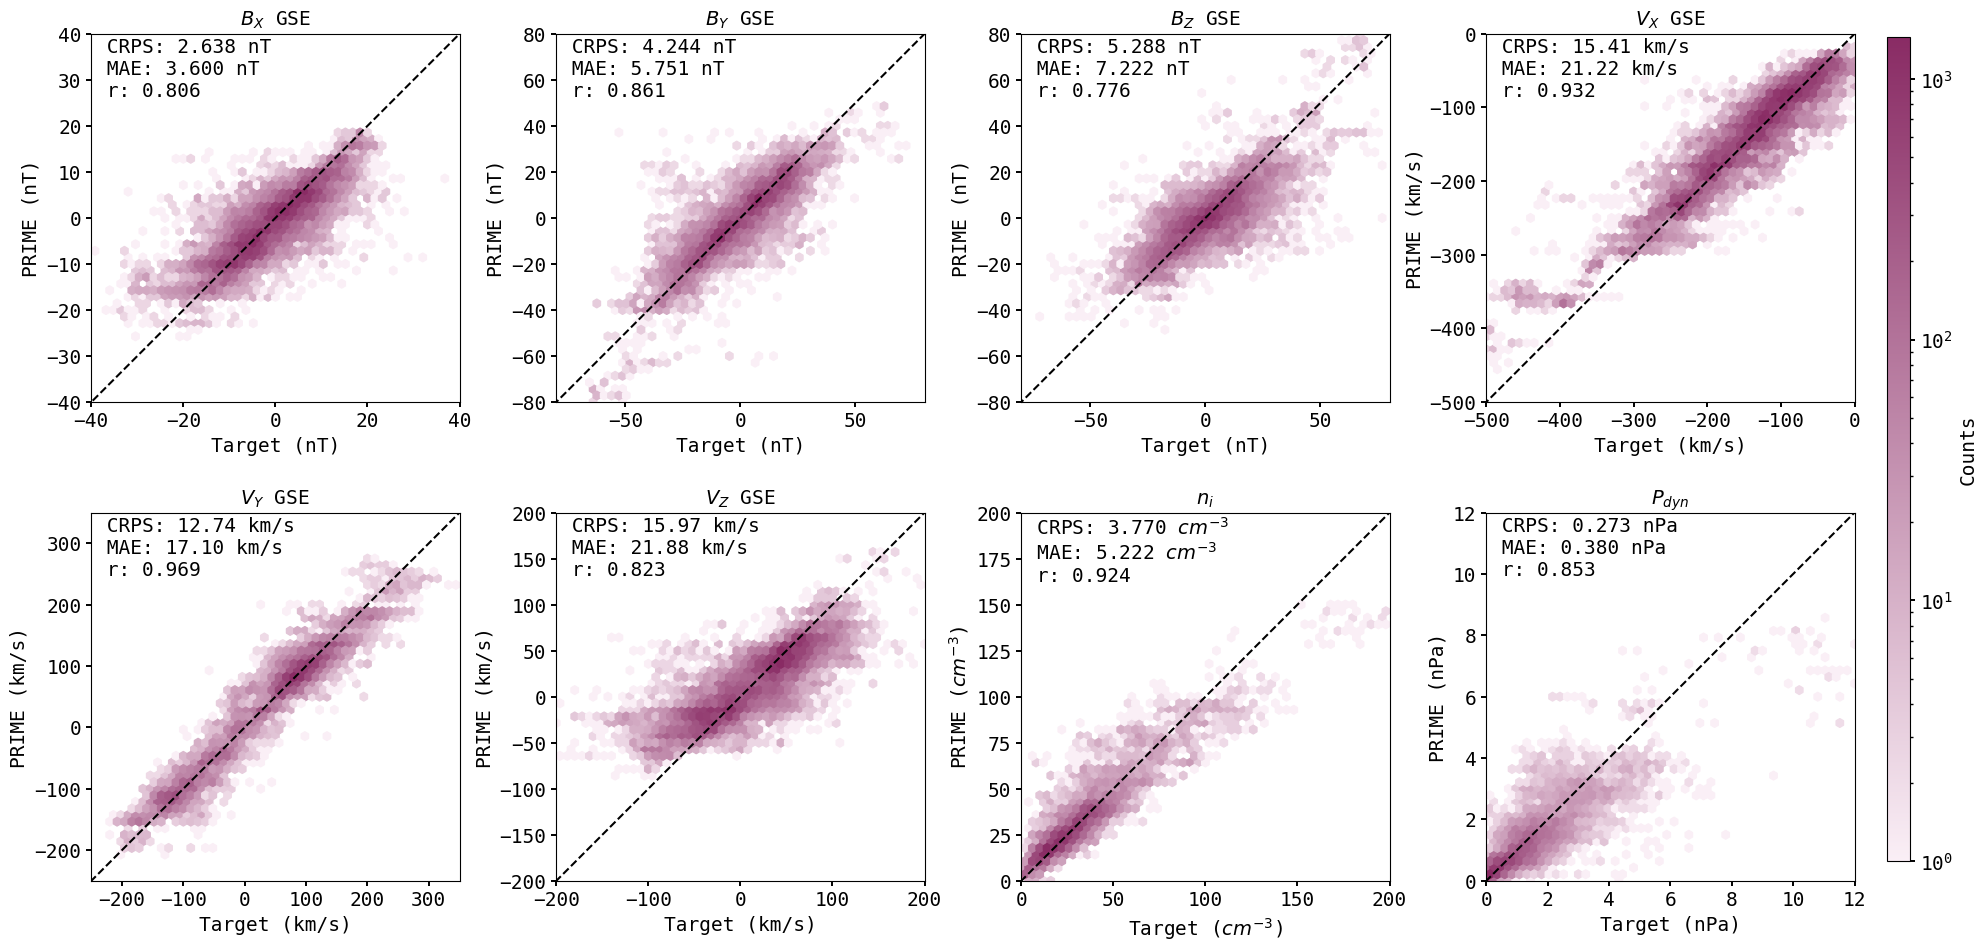

In [9]:
nbins = 50
keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'pdyn'] #Keys for the data parameters to be compared
bounds = [[-40, 40], [-80, 80], [-80, 80], [-500, 0], [-250, 350], [-200, 200],[0,200],[0,12]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE', '$n_{i}$', r'$P_{dyn}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$','nPa']
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(23, 11)
plt.subplots_adjust(hspace = 0.3, wspace=0.2)
for idx, key in enumerate(keys):
    #PRIME in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[idx//4,idx%4].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[idx//4,idx%4].tick_params(axis='both', which='major')
    ax[idx//4,idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_aspect('equal')
    ax[idx//4,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('PRIME ('+units[idx]+')')
    ax[idx//4,idx%4].set_title(titles[idx], fontsize = 14)
    ax[idx//4,idx%4].autoscale(enable=False)
    ax[idx//4,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx//4,idx%4].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first two rows
cbar_ax = fig.add_axes([0.91, 0.128, 0.01, 0.749])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('./plots/prime_jd.pdf', bbox_inches='tight')

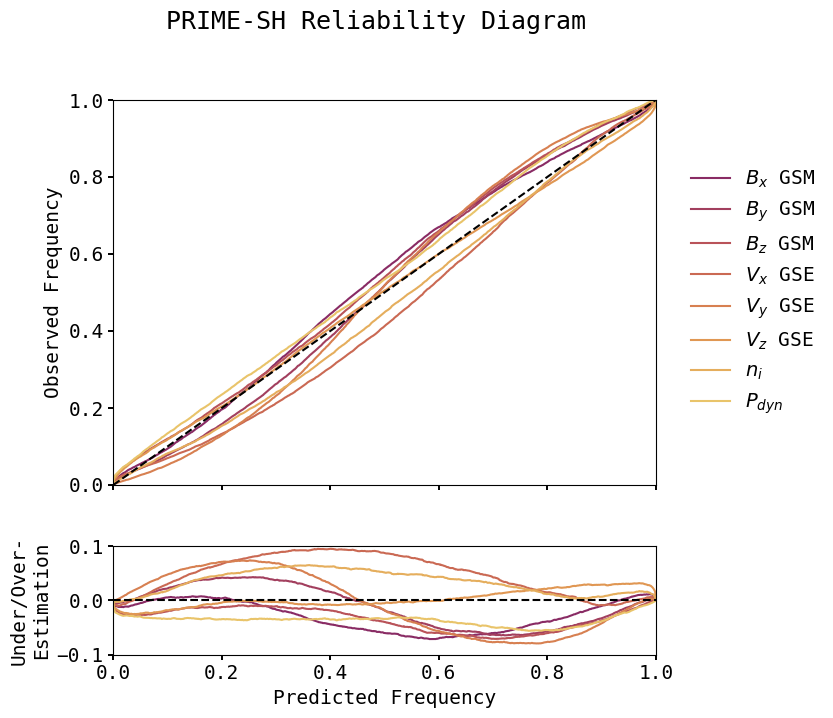

In [11]:
standard_err = (predict_test[keys] - mms_test[keys])/(np.sqrt(2) * predict_test[keys_sig].to_numpy()) #Standard error for each parameter
phi = np.linspace(0,1,1000) #Observed probabily axis
cumulative_dist = np.zeros((len(phi), len(keys))) #Cumulative distribution for each parameter
for idx, key in enumerate(keys):
    for i in standard_err[key].index:
        cumulative_dist[:,idx] += (1/len(standard_err[key])) * np.heaviside(phi - 0.5*(errorfunc(standard_err.loc[i,key])+1) , 1) #Calculate the cumulative distribution for each parameter
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7,9))
color_arr = primesh(np.linspace(0,1,8)) #Color array for each parameter
ax[0].plot(phi, cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[0].plot(phi, cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[0].plot(phi, cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[0].plot(phi, cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[0].plot(phi, cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[0].plot(phi, cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[0].plot(phi, cumulative_dist[:,6], label = r'$n_{i}$', c = color_arr[6])
ax[0].plot(phi, cumulative_dist[:,7], label = r'$P_{dyn}$', c = color_arr[7])
#Place legend in the outside right middle of the figure
ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
ax[0].plot(phi, phi, linestyle = '--', color = 'k')
ax[0].set_ylabel('Observed Frequency')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
fig.suptitle('PRIME-SH Reliability Diagram', fontsize = 18)

ax[1].plot(phi, phi - cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[1].plot(phi, phi - cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[1].plot(phi, phi - cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[1].plot(phi, phi - cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[1].plot(phi, phi - cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[1].plot(phi, phi - cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[1].plot(phi, phi - cumulative_dist[:,6], label = r'$n_{i}$', c = color_arr[6])
ax[1].plot(phi, phi - cumulative_dist[:,7], label = r'$P_{dyn}$', c = color_arr[7])
ax[1].plot(phi, np.zeros(len(phi)), linestyle = '--', color = 'k')
ax[1].set_ylim(-0.1,0.1)
ax[1].set_xlabel('Predicted Frequency')
ax[1].set_ylabel('Under/Over-\nEstimation')
ax[1].set_aspect('equal')
plt.subplots_adjust(hspace = -0.20)
#plt.savefig('./plots/reliability_diagram.pdf', bbox_inches='tight')

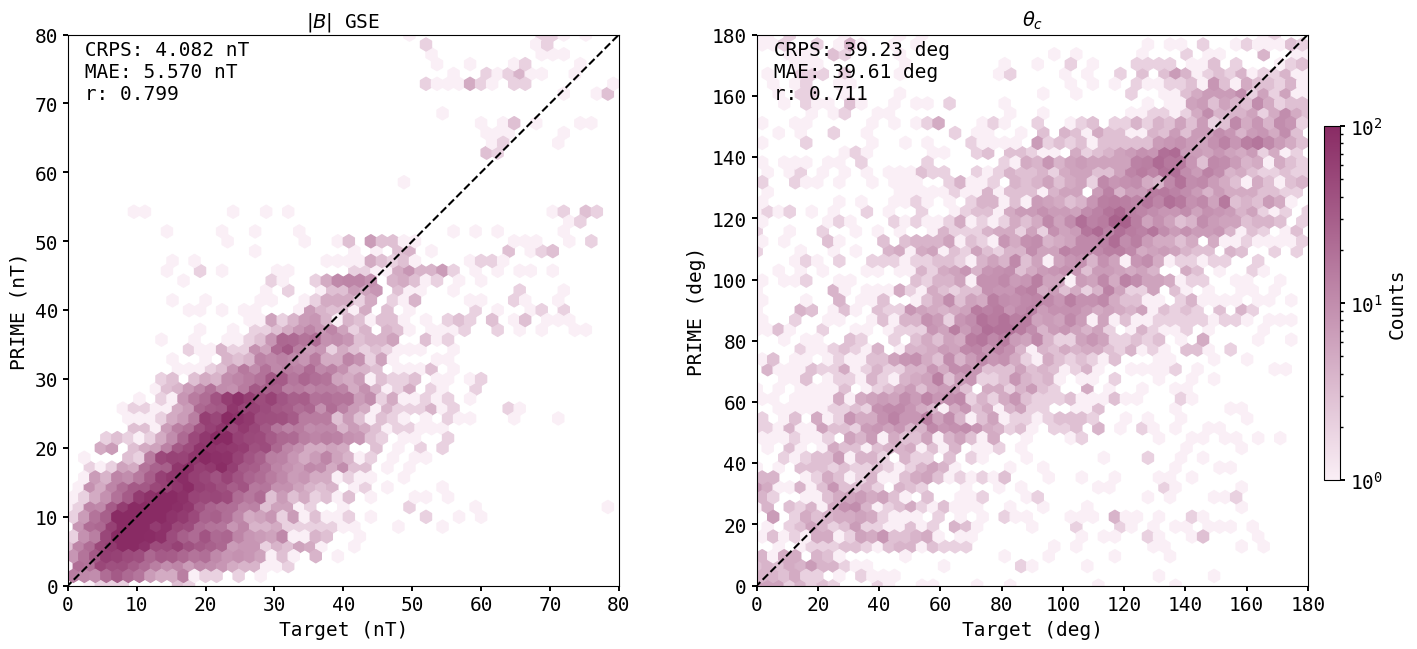

In [13]:
#Plot the joint distributions for derived parameters
nbins = 50
derived_keys = ['B', 'theta']
bounds = [[0, 80], [0, 180]]
titles = [r'$|B|$ GSE',r'$\theta_{c}$']
units = ['nT','deg']
fig, ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(16, 10)
plt.subplots_adjust(hspace = 0.3, wspace=0.25)
for idx, key in enumerate(derived_keys):
    #GRU in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[idx].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[idx].tick_params(axis='both', which='major')
    ax[idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx].set_aspect('equal')
    ax[idx].set_xlabel('Target ('+units[idx]+')')
    ax[idx].set_ylabel('PRIME ('+units[idx]+')')
    ax[idx].set_title(titles[idx], fontsize = 14)
    ax[idx].autoscale(enable=False)
    ax[idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first row
cbar_ax = fig.add_axes([0.91, 0.325, 0.01, 0.354])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('./plots/prime_jd_derived.pdf', bbox_inches='tight')

/tmp/ipykernel_3967/859187108.py:8: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_3967/859187108.py:9: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_3967/859187108.py:10: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_3967/859187108.py:12: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_3967/859187108.py:13: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and 

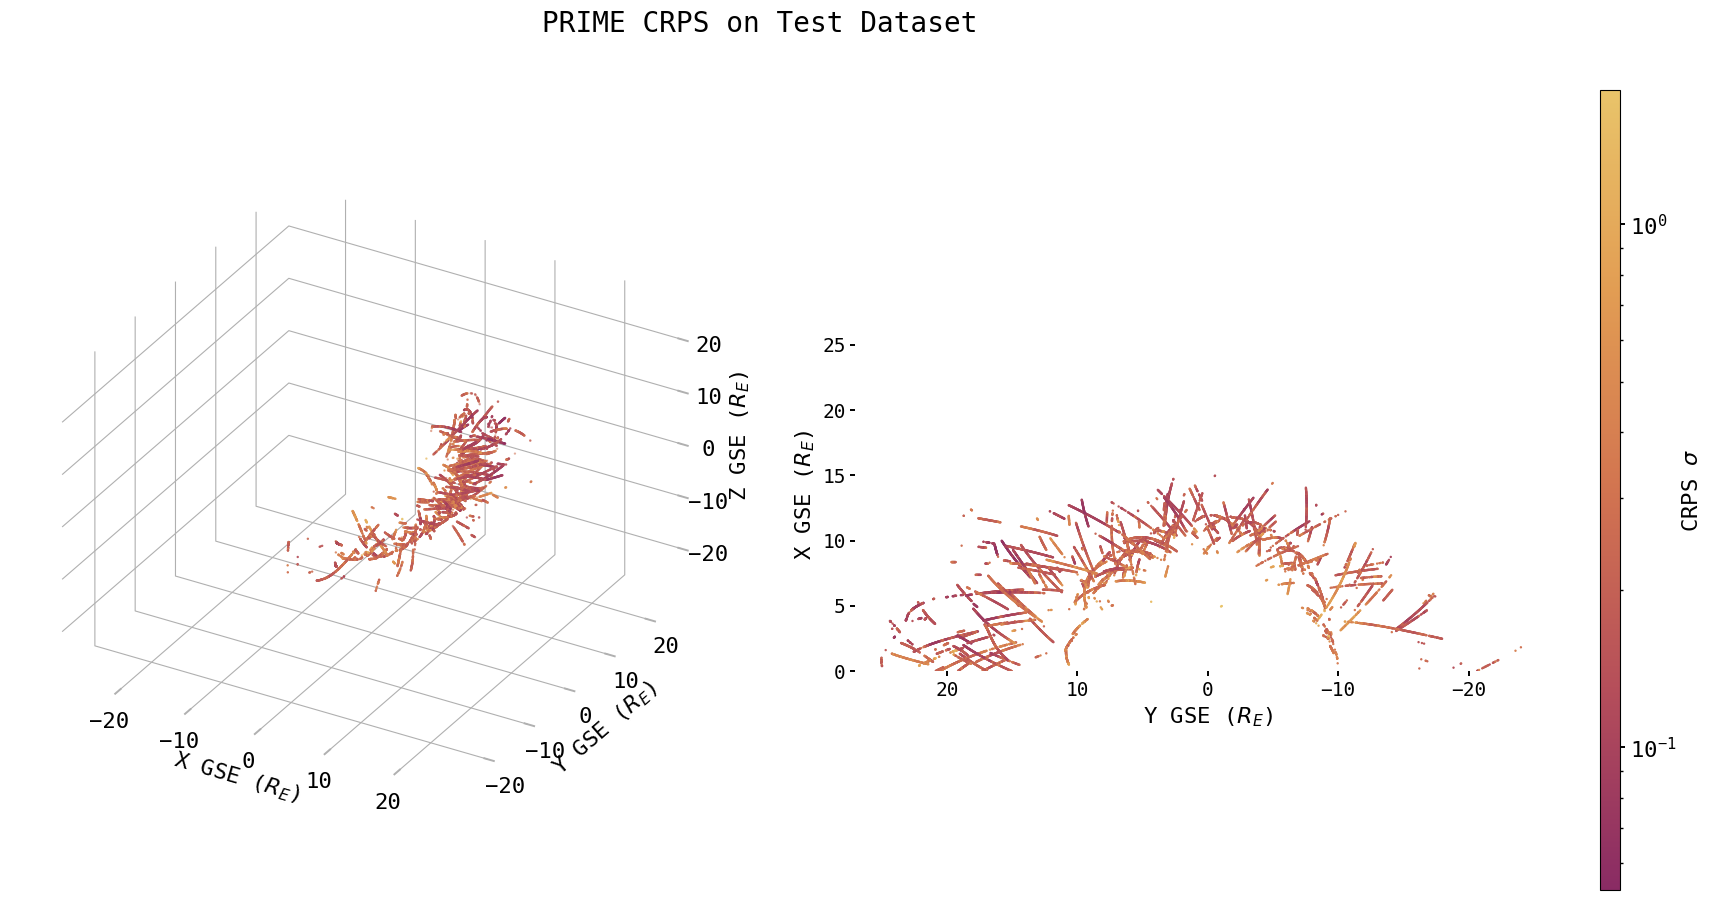

In [14]:
#Plot PRIME's performance (CRPS) in GSE coordinates
fig = plt.figure(figsize=(20,10))
fig.suptitle('PRIME CRPS on Test Dataset', fontsize = 20)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', s = 0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), norm = LogNorm(), label = 'SH Test', cmap = primesh)
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

#ax.plot(wind_data['Px_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Py_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Pz_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, '.', markersize = 0.5, c = c1, label = 'Wind Inputs')
ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='x', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='y', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='z', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_xlim(-27,27)
ax.set_ylim(-27,27)
ax.set_zlim(-27,27)

ax2 = fig.add_subplot(122)
scatter = ax2.scatter(mms_test['R_ygse'], mms_test['R_xgse'], s=0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), norm = LogNorm(), cmap = primesh)
ax2.set_aspect('equal')
ax2.set_ylim(0, 27)
ax2.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
ax2.set_xlim(27, -27)
ax2.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#Add colorbar for scatterplot points on the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'CRPS $\sigma$',fontsize = 16)
cbar.ax.tick_params(labelsize=16)  
#plt.savefig('./plots/crps_3d.pdf', bbox_inches = 'tight')

In [15]:
#Load dataset hyperparameters
hps = pd.read_hdf(modelpath + 'hyperparameters.h5', key = 'sh_hp_20230822', mode = 'a')
fig = plt.figure(figsize = (7, 7))
dotsize = 2000 #Size of the outer dot
steps = [1/2, 1/6] #Steps for the inner dots
scatter = plt.scatter(hps['window'][hps['fraction']==0.15], hps['stride'][hps['fraction']==0.15], c = hps['val_loss'][hps['fraction']==0.15], s = dotsize, vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh)
plt.scatter(hps['window'][hps['fraction']==0.10], hps['stride'][hps['fraction']==0.10], c = hps['val_loss'][hps['fraction']==0.10], s = dotsize*steps[0], vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh)
plt.scatter(hps['window'][hps['fraction']==0.05], hps['stride'][hps['fraction']==0.05], c = hps['val_loss'][hps['fraction']==0.05], s = dotsize*steps[1], vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh)
plt.xlabel('Window Size')
plt.xticks(hps['window'].unique())
plt.xlim(hps['window'].unique().min()-2.5, hps['window'].unique().max()+2.5)
plt.ylabel('Stride')
plt.yticks(hps['stride'].unique())
plt.ylim(hps['stride'].unique().min()-1, hps['stride'].unique().max()+1)
plt.title('Magnetosheath Dataset Hyperparameters', fontsize = 18)
#Remove ticks and spines
plt.gca().tick_params(axis='both', which='major', labelsize=14, color = 'white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
cbar_ax = fig.add_axes([1.02, 0.4, 0.015, 0.5]) #Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax = cbar_ax) #Add the colorbar
#cbar.set_ticks([0.19, 0.20, 0.21])
cbar.outline.set_visible(False) #Remove the colorbar outline
cbar.set_label('CRPS Validation Loss') #Add a label to the colorbar
#plt.savefig(plotpath + 'ds_hyperparameters_20230823.pdf', bbox_inches = 'tight')

FileNotFoundError: File ./modelstore/hyperparameters.h5 does not exist

In [16]:
#Use the Cooling magnetosheath field model to get comparison field
def cooling_imf(b_imf, pdyn, pos):
    '''
    Returns the magnetosheath B field vector in GSM coordinates at the position of the spacecraft.
    Cooling JGR 2001 Model, equation 9 to 12

    Parameters:
        b_imf (list): IMF vector in GSM coordinates (minutely)
        pdyn (float): Solar wind dynamic pressure (minutely)
        pos (list): Position of the spacecraft in GSM coordinates
    Returns:
        b_ms (list): Magnetosheath B field vector in GSM coordinates at the position of the spacecraft
    '''
    rmp = (10.22 + 1.29*np.tanh(0.184*(b_imf[:,2] + 8.14)))*(pdyn**(-1/6.6)) #Magnetopause radius from Shue et al. 1998
    A = 2
    ll = 3 * rmp/2 - pos[:,0]
    b_msx = - A * (- b_imf[:,0] * (1 - rmp / (2 * ll)) + b_imf[:,1]
                * (pos[:,1] / ll) + b_imf[:,2] * (pos[:,2] / ll))
    b_msy = A * (- b_imf[:,0] * (pos[:,1] / (2 * ll)) + b_imf[:,1]
                * (2 - pos[:,1]**2/( ll * rmp)) - b_imf[:,2] * (pos[:,1] * pos[:,2] / (ll * rmp)))
    b_msz = A * (- b_imf[:,0] * (pos[:,2] / (2 * ll)) - b_imf[:,1]
                * (pos[:,1] * pos[:,2] / (ll * rmp)) + b_imf[:,2] * (2 - pos[:,2]**2 / (ll * rmp)))
    b_ms = np.array([b_msx, b_msy, b_msz])
    return b_ms
omni_bs = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_bs', mode = 'a') #load shifted omni data
omni_bs_cooling = omni_bs.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_bs['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
omni_bs_cooling.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_bs_cooling.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
omni_bs_cooling['pdyn'] = sw.pdyn(omni_bs_cooling['Ni'], omni_bs_cooling['Vi_xgse'])
b_ms = cooling_imf(omni_bs_cooling[['B_xgsm', 'B_ygsm', 'B_zgsm']].to_numpy(), omni_bs_cooling['pdyn'].to_numpy(), mms_test[['R_xgse', 'R_ygse', 'R_zgse']].to_numpy())
b_ms = pd.DataFrame(b_ms.T, columns = ['B_xgsm', 'B_ygsm', 'B_zgsm'], index = mms_test.index)
b_ms['Epoch'] = mms_test['Epoch']
b_ms['B'] = np.sqrt(b_ms['B_ygsm']**2 + b_ms['B_zgsm']**2)
b_ms['theta'] = np.arctan2(b_ms['B_ygsm'], b_ms['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the Cooling model generated field
b_ms.index = mms_test.index

/tmp/ipykernel_3967/3687696700.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_bs_cooling.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
/tmp/ipykernel_3967/3687696700.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_bs_cooling['pdyn'] = sw.pdyn(omni_bs_cooling['Ni'], omni_bs_cooling['Vi_xgse'])


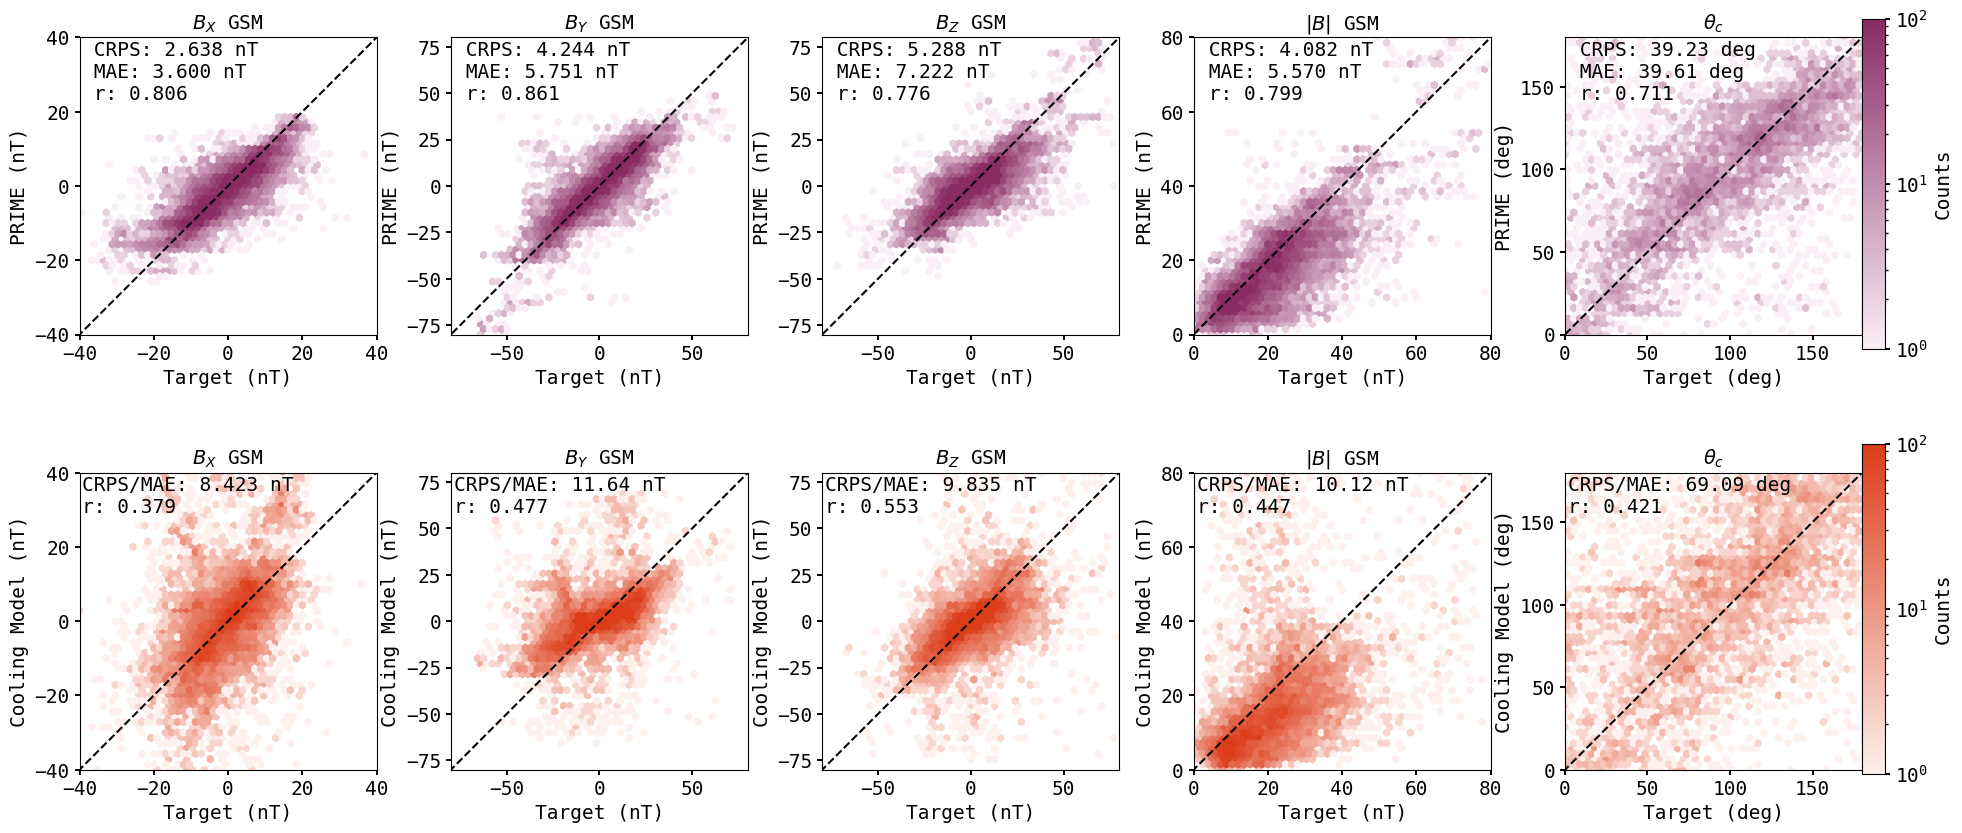

In [17]:
#Plot the joint distributions for derived parameters
nbins = 50
derived_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'B', 'theta']
bounds = [[-40, 40], [-80, 80], [-80, 80], [0, 80], [0, 180]]
titles = [r'$B_{X}$ GSM',r'$B_{Y}$ GSM',r'$B_{Z}$ GSM',r'$|B|$ GSM',r'$\theta_{c}$']
units = ['nT','nT','nT','nT','deg']
fig, ax = plt.subplots(nrows=2,ncols=5)
fig.set_size_inches(23, 10)
plt.subplots_adjust(hspace = 0.3, wspace=0.25)
for idx, key in enumerate(derived_keys):
    #GRU in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[0,idx].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[0,idx].tick_params(axis='both', which='major')
    ax[0,idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[0,idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[0,idx].set_aspect('equal')
    ax[0,idx].set_xlabel('Target ('+units[idx]+')')
    ax[0,idx].set_ylabel('PRIME ('+units[idx]+')')
    ax[0,idx].set_title(titles[idx], fontsize = 14)
    ax[0,idx].autoscale(enable=False)
    ax[0,idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[0,idx].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[0,idx].transAxes, color = 'k', fontsize = 14)
    
    #Cooling model in the bottom
    pred_temp = b_ms[key]
    pred_temp.where((pred_temp < mms_test[key].max())&(pred_temp > mms_test[key].min()), np.nan, inplace = True)
    pred_temp = pred_temp.dropna()
    mms_temp = mms_test[key][pred_temp.index]
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im2 = ax[1,idx].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_oranges)
    ax[1,idx].tick_params(axis='both', which='major')
    ax[1,idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[1,idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[1,idx].set_aspect('equal')
    ax[1,idx].set_xlabel('Target ('+units[idx]+')')
    ax[1,idx].set_ylabel('Cooling Model ('+units[idx]+')')
    ax[1,idx].set_title(titles[idx], fontsize = 14)
    ax[1,idx].autoscale(enable=False)
    ax[1,idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    cooling_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    cooling_r, cooling_p = sps.pearsonr(pred_temp.to_numpy(), mms_temp.to_numpy())
    ax[1,idx].text(.01, .99, 'CRPS/MAE: ' + str(cooling_mae)[0:5] + ' '+units[idx]+'\nr: ' + str(cooling_r)[0:5], ha='left', va='top', transform = ax[1,idx].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first row
cbar_ax = fig.add_axes([0.90, 0.55, 0.01, 0.33])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Put colorbar for im2 on the right of the last row
cbar_ax = fig.add_axes([0.90, 0.125, 0.01, 0.33])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('./plots/prime_cooling_derived.pdf', bbox_inches='tight')

In [18]:
import tensorflow as tf
from tensorflow import keras as ks

#Load the model
model = ks.Sequential([ks.layers.GRU(units=544),
                      ks.layers.Dense(units=224, activation='elu'),
                      ks.layers.Dense(units=64, activation='elu'),
                      ks.layers.Dense(units=80, activation='elu'),
                      ks.layers.LayerNormalization(),
                      ks.layers.Dropout(0.35),
                      ks.layers.Dense(14,activation='linear')
                      ])
model.compile(optimizer=tf.optimizers.Adamax(learning_rate=1e-4), loss=ksc.crps_loss)
model.build(input_shape = (None, 55, 14))

#Load the model weights
model.load_weights(modelpath + 'sheathmodel_weights.h5')
model.summary()

2023-09-21 10:10:13.652835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-21 10:10:13.654266: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-21 10:10:13.655305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-NV8RI4S): /proc/driver/nvidia/version does not exist
2023-09-21 10:10:13.665927: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 544)               913920    
                                                                 
 dense (Dense)               (None, 224)               122080    
                                                                 
 dense_1 (Dense)             (None, 64)                14400     
                                                                 
 dense_2 (Dense)             (None, 80)                5200      
                                                                 
 layer_normalization (LayerN  (None, 80)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                        

In [49]:
class primesh(ks.Model):
    def __init__(self, model = None, in_scaler = None, tar_scaler = None):
        '''
        Class to wrap a keras model to be used with the SH dataset.

        Parameters:
            model (keras model): Keras model to be used for prediction
            in_scaler (sklearn scaler): Scaler to be used for input data
            tar_scaler (sklearn scaler): Scaler to be used for target data
        '''
        super(primesh, self).__init__()
        if model is None:
            self.model = self.build_model()
            self.model.load_weights('primesh.h5')
            self.model = model
        else:
            self.model = model
        if in_scaler is None:
            self.in_scaler = joblib.load('in_scaler.pkl')
        else:
            self.in_scaler = in_scaler
        if tar_scaler is None:
            self.tar_scaler = joblib.load('tar_scaler.pkl')
        else:
            self.tar_scaler = tar_scaler
    def predict(self, input):
        '''
        Wrapper function to scale input data and predict with a keras model.
        
        Parameters:
            input (array): Input data to be scaled and predicted
        Returns:
            output (array): Scaled output data
        '''
        input_scaled = self.in_scaler.transform(input)
        input_arr = np.zeros((len(input_scaled)//55, 55, 14)) #Reshape input data to be 3D
        for i in np.arange(len(input_scaled)//55):
            input_arr[i,:,:] = input_scaled[i*55:(i+1)*55] #Move the 55 unit window through the input data
        output_unscaled = self.model.predict(input_arr)
        output = np.zeros((len(output_unscaled),14)) #Stage output data to be 14 units (2x target dimensions)
        output[:, ::2] = self.tar_scaler.inverse_transform(output_unscaled[:, ::2]) #Mean values
        output[:, 1::2] = np.abs(self.tar_scaler.inverse_transform(output_unscaled[:, ::2] + output_unscaled[:, 1::2]) - self.tar_scaler.inverse_transform(output_unscaled[:, ::2])) #Standard deviations
        return output
    def load_weights(self, modelpath, scalerpath):
        '''
        Wrapper function to load saved keras model and scalers
        
        Parameters:
            modelpath (str): Path to saved keras model
            scalerpath (str): Path to saved scalers
        '''
        self.model.load_weights(modelpath)
        self.in_scaler = joblib.load(scalerpath + 'in_scaler.pkl')
        self.tar_scaler = joblib.load(scalerpath + 'tar_scaler.pkl')
    def save_weights(self, modelpath, scalerpath):
        '''
        Wrapper function to save keras model and scalers

        Parameters:
            modelpath (str): Path to save keras model
            scalerpath (str): Path to save scalers
        '''
        self.model.save_weights(modelpath)
        joblib.dump(self.in_scaler, scalerpath + 'in_scaler.pkl')
        joblib.dump(self.tar_scaler, scalerpath + 'tar_scaler.pkl')
    def build_model(self):
        '''
        Function to build keras model
        
        Returns:
            model (keras model): Keras model to be used for prediction
        '''
        model = ks.Sequential([ks.layers.GRU(units=544),
                               ks.layers.Dense(units=224, activation='elu'),
                               ks.layers.Dense(units=64, activation='elu'),
                               ks.layers.Dense(units=80, activation='elu'),
                               ks.layers.LayerNormalization(),
                               ks.layers.Dropout(0.35),
                               ks.layers.Dense(14,activation='linear')
                               ])
        model.compile(optimizer=tf.optimizers.Adamax(learning_rate=1e-4), loss=ksc.crps_loss)
        model.build(input_shape = (1, 55, 14))
        return model

In [45]:
prime = primesh(model, ds.in_scaler, ds.tar_scaler)

In [100]:
fake_data = pd.DataFrame(columns=in_keys)
length = 10
for key in fake_data.columns:
    fake_data[key] = np.mean(wind_data[key][wind_data['flag'] != 1])*np.ones(55*length)
fake_data['B_zgsm'][int(len(fake_data)/2):] = -30 #Set B_zgsm to -30 nT halfway through the dataset
fake_data_arr = np.zeros((len(fake_data[:-54]), 55, 14))
for i in np.arange(len(fake_data[:-54])):
    fake_data_arr[i,:,:] = prime.in_scaler.transform(fake_data.iloc[i:(i+55)].to_numpy())
output_unscaled = prime.model.predict(fake_data_arr)
output = np.zeros((len(output_unscaled),14)) #Stage output data to be 14 units (2x target dimensions)
output[:, ::2] = prime.tar_scaler.inverse_transform(output_unscaled[:, ::2]) #Mean values
output[:, 1::2] = np.abs(prime.tar_scaler.inverse_transform(output_unscaled[:, ::2] + output_unscaled[:, 1::2]) - prime.tar_scaler.inverse_transform(output_unscaled[:, ::2])) #Standard deviations
output_keys = ['B_xgsm', 'B_xgsm_sig', 'B_ygsm', 'B_ygsm_sig', 'B_zgsm', 'B_zgsm_sig', 'Vi_xgse', 'Vi_xgse_sig', 'Vi_ygse', 'Vi_ygse_sig', 'Vi_zgse', 'Vi_zgse_sig', 'Ni', 'Ni_sig']
output = pd.DataFrame(output, columns = output_keys)

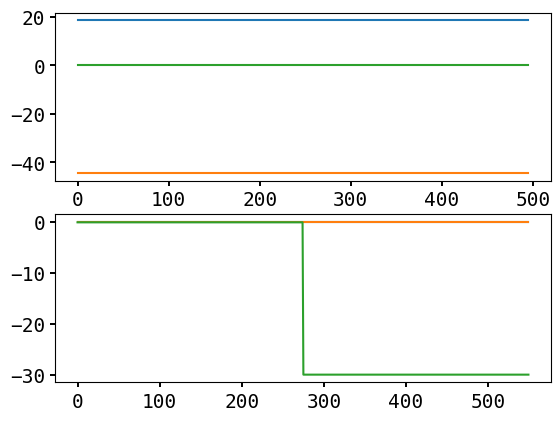

In [101]:
fig, axes = plt.subplots(nrows = 2, ncols=1)
axes[0].plot(output['B_xgsm'], label = 'B_xgsm')
axes[0].plot(output['B_ygsm'], label = 'B_ygsm')
axes[0].plot(output['B_zgsm'], label = 'B_zgsm')

axes[1].plot(fake_data['B_xgsm'], label = 'B_xgsm_in')
axes[1].plot(fake_data['B_ygsm'], label = 'B_ygsm_in')
axes[1].plot(fake_data['B_zgsm'], label = 'B_zgsm_in')


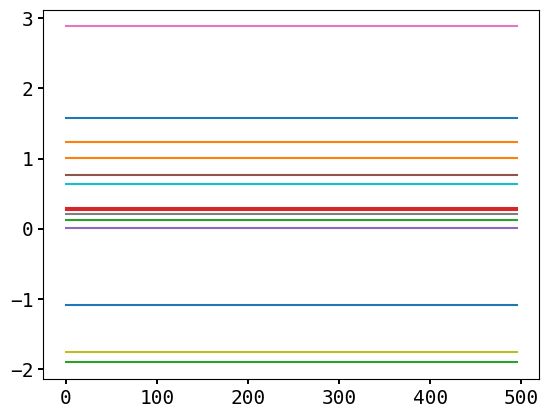

In [102]:
for i in np.arange(output_unscaled.shape[1]):
    plt.plot(output_unscaled[:,i], label = output_keys[i])

In [105]:
fake_data_arr[int(len(fake_data)/2)-10,:,2]

array([-1.05678501e-03, -1.05678501e-03, -1.05678501e-03, -1.05678501e-03,
       -1.05678501e-03, -1.05678501e-03, -1.05678501e-03, -1.05678501e-03,
       -1.05678501e-03, -1.05678501e-03, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -8.80768464e+00, -8.80768464e+00, -8.80768464e+00,
       -8.80768464e+00, -